In [98]:
import pandas as pd

# classification dataset for voting ensemble
classification_data = pd.read_csv("./classification_data_cleaned.csv")
# regression dataset for decision tree models 
regression_data = pd.read_csv("./regression_data_cleaned_dead.csv")



In [99]:
# prepare data for classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
x_clf = classification_data.drop(columns=["Mortality_Status"])
y_clf = classification_data["Mortality_Status"]

# Train-test split
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(
    x_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# inspect and encode
print(x_train_clf.dtypes[x_train_clf.dtypes == 'object'])




6th_Stage         object
Differentiated    object
A_Stage           object
dtype: object


In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Step 1: One-hot encode the 3 object columns
x_train_clf = pd.get_dummies(x_train_clf, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)
x_test_clf = pd.get_dummies(x_test_clf, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)

# Step 2: Align the test set to have the same columns as train set
X_train_clf, X_test_clf = x_train_clf.align(x_test_clf, join='left', axis=1, fill_value=0)

imputer = SimpleImputer(strategy='median')
x_train_clf = imputer.fit_transform(x_train_clf)
x_test_clf = imputer.transform(x_test_clf)

# Step 3: Standardize the features
scaler = StandardScaler()
x_train_clf_scaled = scaler.fit_transform(x_train_clf)
x_test_clf_scaled = scaler.transform(x_test_clf)


In [101]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Create base models
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)

# Ensemble: Voting
voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("knn", knn)],
    voting='soft'  # 'soft' uses predicted probabilities
)

voting_clf.fit(x_train_clf_scaled, y_train_clf)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [102]:
from sklearn.metrics import classification_report, roc_auc_score



y_pred = voting_clf.predict(x_test_clf_scaled)
y_probs = voting_clf.predict_proba(x_test_clf_scaled)[:, 1]

print("Classification Report:\n", classification_report(y_test_clf, y_pred))
print("AUC Score:", roc_auc_score(y_test_clf, y_probs))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       682
           1       0.61      0.14      0.23       123

    accuracy                           0.85       805
   macro avg       0.74      0.56      0.57       805
weighted avg       0.82      0.85      0.81       805

AUC Score: 0.6986624704956728


In [103]:
# prepare the regression data
x_reg = regression_data.drop(columns=["Survival_Months"])
y_reg = regression_data["Survival_Months"]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    x_reg, y_reg, test_size=0.2, random_state=42
)


In [104]:
x_train_reg = pd.get_dummies(x_train_reg, drop_first=True)
x_test_reg = pd.get_dummies(x_test_reg, drop_first=True)

# Align columns so test matches train
x_train_reg, x_test_reg = x_train_reg.align(x_test_reg, join="left", axis=1, fill_value=0)


In [105]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

x_train_reg = pd.DataFrame(imputer.fit_transform(x_train_reg), columns=x_train_reg.columns)
x_test_reg = pd.DataFrame(imputer.transform(x_test_reg), columns=x_test_reg.columns)


In [110]:
# train decision tree models
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Fully grown tree
dt1 = DecisionTreeRegressor(random_state=42)
dt1.fit(x_train_reg, y_train_reg)

# Pruned tree (max_depth = 4)
dt2 = DecisionTreeRegressor(max_depth=4, random_state=42)
dt2.fit(x_train_reg, y_train_reg)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [111]:
# evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_regressor(model, x_test, y_test, name):
    y_pred = model.predict(x_test)
    print(f"--- {name} ---")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    print()

evaluate_regressor(dt1, x_test_reg, y_test_reg, "Fully Grown Tree")
evaluate_regressor(dt2, x_test_reg, y_test_reg, "Pruned Tree (max_depth=4)")

--- Fully Grown Tree ---
MAE: 25.241935483870968
MSE: 1042.9516129032259
R²: -0.8987831816494021

--- Pruned Tree (max_depth=4) ---
MAE: 19.002734374507494
MSE: 619.3142872372644
R²: -0.1275149663826436



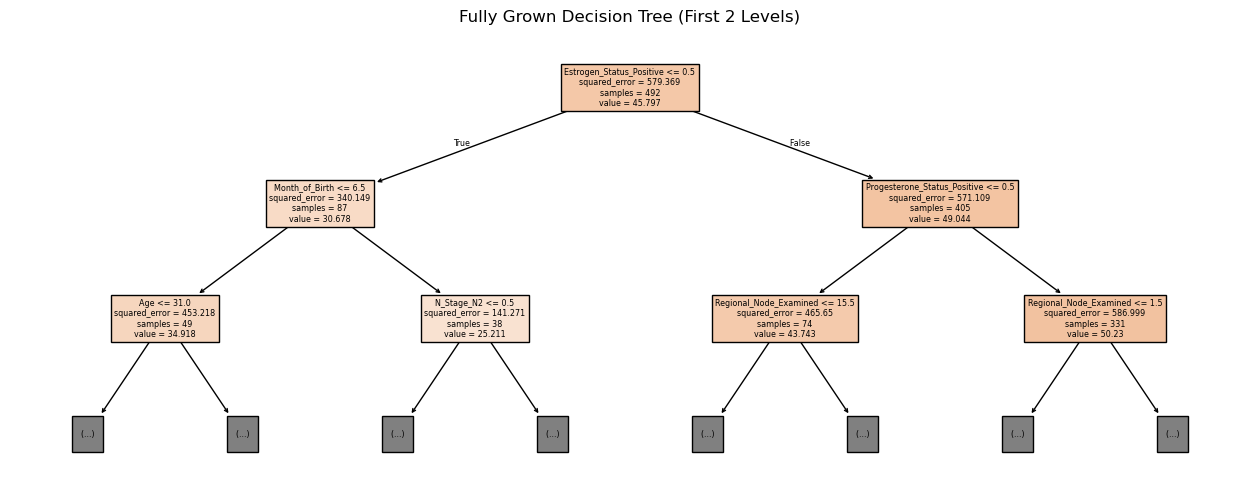

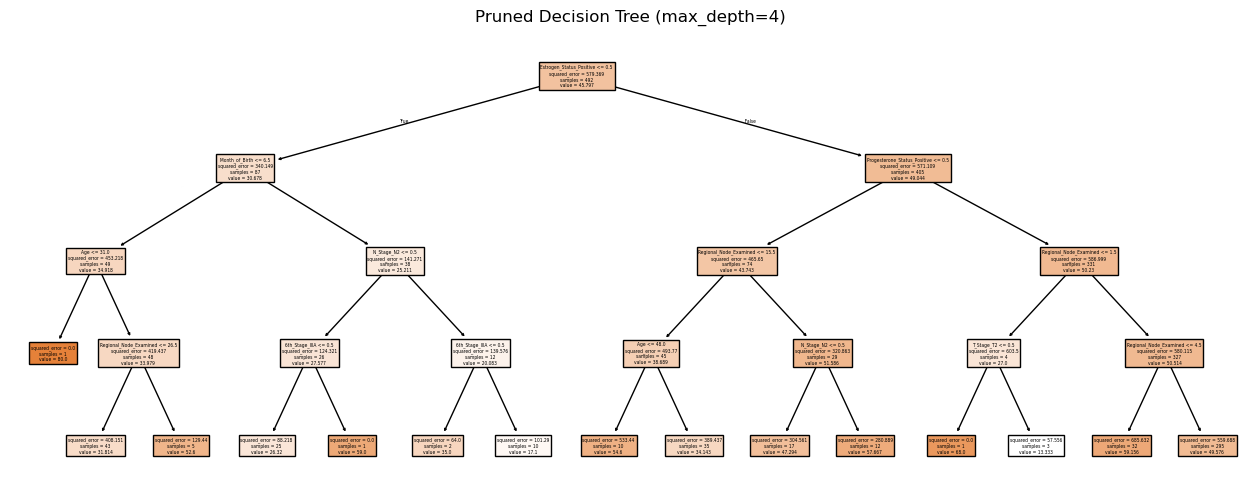

In [112]:
import matplotlib.pyplot as plt


# visualize tree
plt.figure(figsize=(16, 6))
plot_tree(dt1, filled=True, max_depth=2, feature_names=x_train_reg.columns)
plt.title("Fully Grown Decision Tree (First 2 Levels)")
plt.show()

plt.figure(figsize=(16, 6))
plot_tree(dt2, filled=True, feature_names=x_train_reg.columns)
plt.title("Pruned Decision Tree (max_depth=4)")
plt.show()